# Batch GP Baseline Plots for SkyPatrol LCs

This notebook runs `per_camera_gp_baseline` for all `../../data/skypatrol2/*.csv` files using `df_plot.plot_many_lc`. Adjust the hyperparameters below as needed.



In [4]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

# Ensure repo root is on sys.path (works when running from malca/notebooks)
HERE = Path.cwd().resolve()

def find_repo_root(start: Path) -> Path:
    for p in (start, *start.parents):
        if (p / "pyproject.toml").exists() and (p / "malca").is_dir():
            return p
    return start

REPO_ROOT = find_repo_root(HERE)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from malca.plot import plot_bayes_results
from malca.baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

# Input data
SKYPATROL_ROOT = Path("../../input/skypatrol2")
SKYPATROL_CSV_PATHS = sorted(SKYPATROL_ROOT.glob("*.csv"))

# Where to save outputs
OUT_DIR = Path("../../lc_plots/skypatrol_gp")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# GP hyperparameters (tune as desired)
gp_kwargs = {
    "sigma": 0.08,   # mag amplitude; lower to smooth more
    "rho": 150.0,    # characteristic timescale (days); higher to smooth more
    "q": 0.7,        # damping; <1 reduces oscillation
    "jitter": 0.006, # mag floor; set >= median photometric error
}

# Plot params
PLOT_KW = {
    "out_format": "pdf",  # change to "png" if you prefer
    "show": False,         # set True to display inline (slower)
    "skip_events": True,   # baseline/residuals only
    "plot_fits": False,
}


def plot_many_baselines(
    paths,
    *,
    baseline_func,
    baseline_kwargs,
    out_dir,
    out_format="pdf",
    show=False,
    skip_events=True,
    plot_fits=False,
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results = []
    for csv_path in paths:
        csv_path = Path(csv_path)
        out_path = out_dir / f"{csv_path.stem}.{out_format}"
        try:
            plot_bayes_results(
                csv_path,
                out_path=out_path,
                baseline_func=baseline_func,
                baseline_kwargs=baseline_kwargs,
                show=show,
                skip_events=skip_events,
                plot_fits=plot_fits,
            )
            results.append(out_path)
        except Exception as exc:
            print(f"Skipping {csv_path}: {exc}")
    return results


print("Input directory:", SKYPATROL_ROOT.resolve())
print("Found CSVs:", len(SKYPATROL_CSV_PATHS))
print("Output directory:", OUT_DIR.resolve())


Input directory: /Users/calder/code/malca/input/skypatrol2
Found CSVs: 28
Output directory: /Users/calder/code/malca/lc_plots/skypatrol_gp


# Batch GP baseline plots (SkyPatrol)

Use `plot_many_baselines` with `per_camera_gp_baseline` to process all `../../input/skypatrol2/*.csv` files.


In [5]:
results = plot_many_baselines(
    SKYPATROL_CSV_PATHS,
    baseline_func=per_camera_gp_baseline,
    baseline_kwargs=gp_kwargs,
    out_dir=OUT_DIR,
    **PLOT_KW,
)

print(f"Saved {len(results)} files to {OUT_DIR.resolve()}")
for r in results[:5]:
    print("-", r)
if len(results) > 5:
    print("...", len(results) - 5, "more")


Analyzing 120259184943...


/opt/miniconda3/envs/malca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved plot to ../../lc_plots/skypatrol_gp/120259184943-light-curves.pdf
Analyzing 223339338105...
Saved plot to ../../lc_plots/skypatrol_gp/223339338105-light-curves.pdf
Analyzing 231929175915...
Saved plot to ../../lc_plots/skypatrol_gp/231929175915-light-curves.pdf
Analyzing 25770019815...
Saved plot to ../../lc_plots/skypatrol_gp/25770019815-light-curves.pdf
Analyzing 266288137752...
Saved plot to ../../lc_plots/skypatrol_gp/266288137752-light-curves.pdf
Analyzing 317827964025...
Saved plot to ../../lc_plots/skypatrol_gp/317827964025-light-curves.pdf
Analyzing 326417831663...
Saved plot to ../../lc_plots/skypatrol_gp/326417831663-light-curves.pdf
Analyzing 335007754417...
Saved plot to ../../lc_plots/skypatrol_gp/335007754417-light-curves.pdf
Analyzing 352187470767...
Saved plot to ../../lc_plots/skypatrol_gp/352187470767-light-curves.pdf
Analyzing 360777377116...
Saved plot to ../../lc_plots/skypatrol_gp/360777377116-light-curves.pdf
Analyzing 377957522430...
Saved plot to ../../lc

## Baseline function smoke tests

Quick synthetic checks to ensure each baseline variant returns `baseline`, `resid`, and `sigma_resid` with finite values on a small synthetic dataset.


In [6]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 40
jd = np.arange(N, dtype=float)
trend = 0.002 * jd
noise = np.random.normal(0, 0.01, N)
mag = 15.0 + trend + 0.1 * np.sin(jd / 6.0) + noise
err = np.full(N, 0.02, dtype=float)
cam = np.where(jd < N / 2, "A", "B")

df_synth = pd.DataFrame(
    {
        "JD": jd,
        "mag": mag,
        "error": err,
        "camera#": cam,
    }
)

def check_baseline_output(df, name):
    required = {"baseline", "resid", "sigma_resid"}
    assert required.issubset(df.columns), f"{name}: missing columns"
    finite_baseline = np.isfinite(df["baseline"])
    finite_resid = np.isfinite(df["resid"])
    finite_sigma = np.isfinite(df["sigma_resid"])
    assert finite_baseline.any(), f"{name}: baseline all-NaN"
    assert finite_resid.any(), f"{name}: resid all-NaN"
    assert finite_sigma.any(), f"{name}: sigma_resid all-NaN"
    print(f"{name}: ok ({finite_baseline.sum()} finite baselines)")


In [7]:
from malca.baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

tests = [
    ("global_mean_baseline", global_mean_baseline, {}),
    ("global_median_baseline", global_median_baseline, {}),
    ("global_rolling_median_baseline", global_rolling_median_baseline, {"days": 40.0, "min_points": 5}),
    ("global_rolling_mean_baseline", global_rolling_mean_baseline, {"days": 20.0, "min_points": 5}),
    ("per_camera_mean_baseline", per_camera_mean_baseline, {}),
    ("per_camera_median_baseline", per_camera_median_baseline, {"days": 40.0, "min_points": 5}),
    (
        "per_camera_trend_baseline",
        per_camera_trend_baseline,
        {"days_short": 40.0, "days_long": 80.0, "min_points": 5, "last_window_guard": 10.0},
    ),
    (
        "per_camera_gp_baseline",
        per_camera_gp_baseline,
        {"sigma": 0.05, "rho": 20.0, "q": 0.7, "jitter": 0.01},
    ),
    (
        "per_camera_gp_baseline_masked",
        per_camera_gp_baseline_masked,
        {"a1": 0.01, "rho1": 50.0, "a2": 0.005, "rho2": 100.0, "jitter": 0.01},
    ),
]

for name, func, kwargs in tests:
    df_out = func(df_synth, **kwargs)
    check_baseline_output(df_out, name)

global_mean_baseline: ok (40 finite baselines)
global_median_baseline: ok (40 finite baselines)
global_rolling_median_baseline: ok (36 finite baselines)
global_rolling_mean_baseline: ok (36 finite baselines)
per_camera_mean_baseline: ok (40 finite baselines)
per_camera_median_baseline: ok (32 finite baselines)
per_camera_trend_baseline: ok (32 finite baselines)
per_camera_gp_baseline: ok (40 finite baselines)
per_camera_gp_baseline_masked: ok (40 finite baselines)


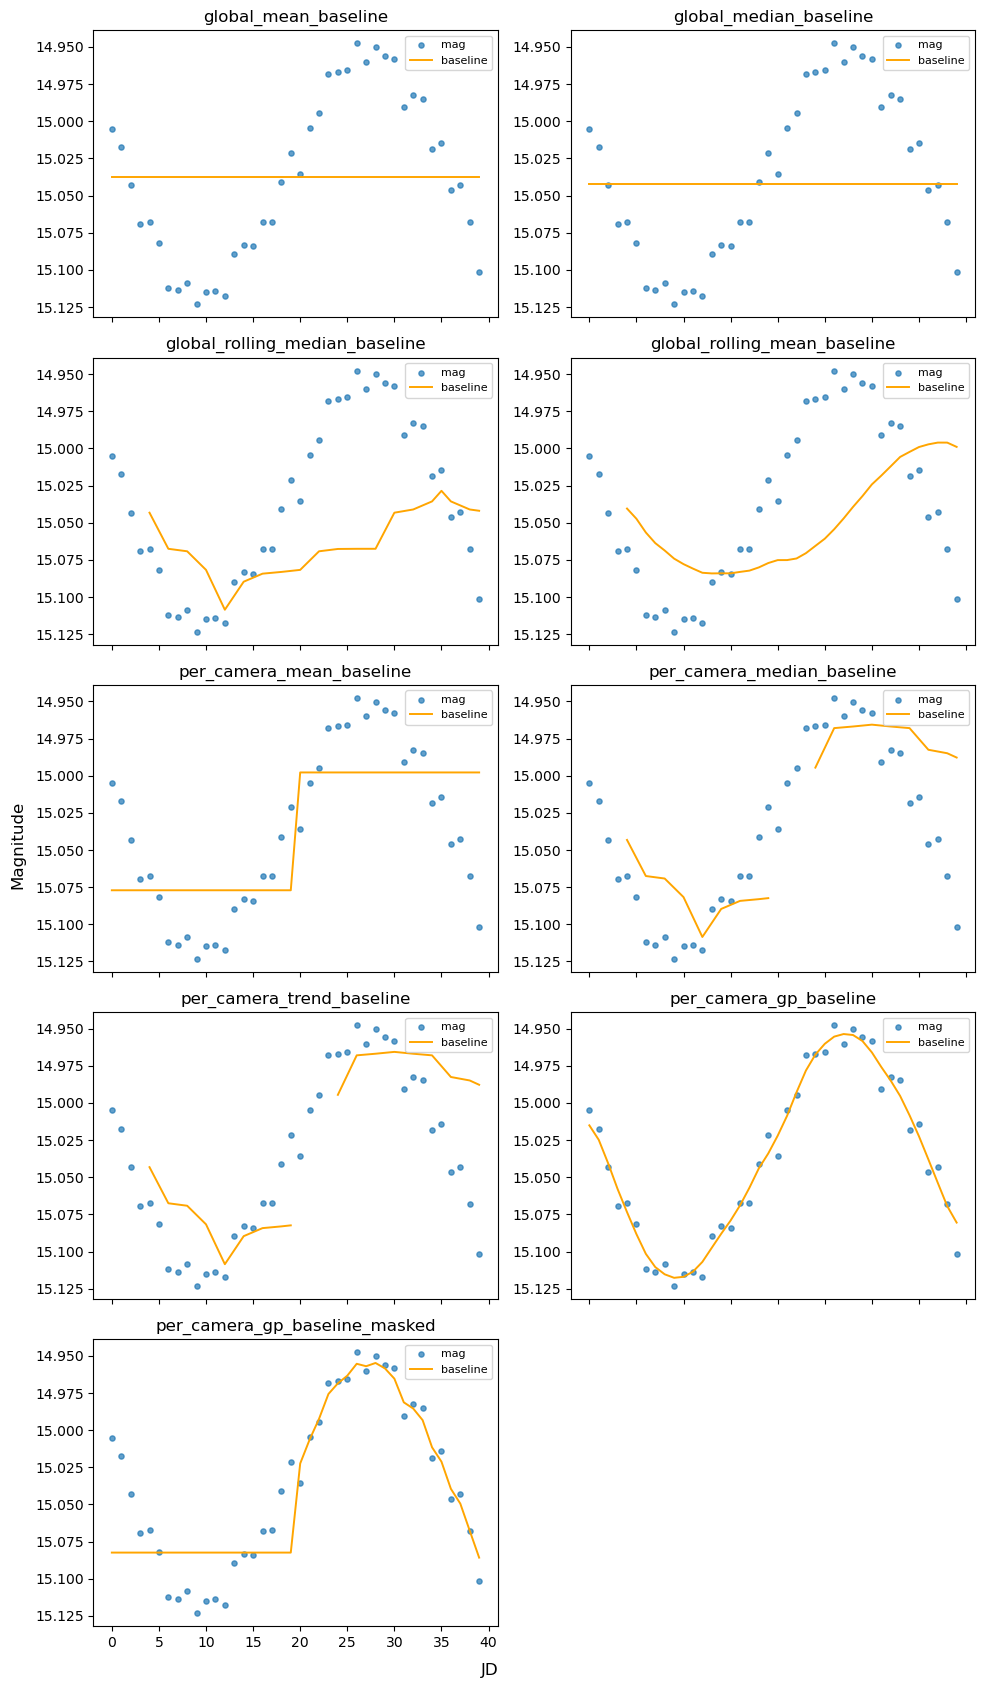

In [8]:

n = len(tests)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3.4 * nrows), sharex=True)
axes = axes.flatten()

for ax, (name, func, kwargs) in zip(axes, tests):
    df_out = func(df_synth, **kwargs)
    ax.scatter(df_out["JD"], df_out["mag"], s=14, alpha=0.7, label="mag")
    ax.plot(df_out["JD"], df_out["baseline"], color="orange", lw=1.4, label="baseline")
    ax.set_title(name)
    ax.invert_yaxis()
    ax.legend(loc="best", fontsize=8)

for ax in axes[n:]:
    ax.axis("off")

fig.supxlabel("JD")
fig.supylabel("Magnitude")
plt.tight_layout()
plt.show()



## Batch baselines on SkyPatrol data

Run every baseline function over all `SKYPATROL_CSV_PATHS` and write plots to `../../lc_plots/skypatrol_all_baselines/<baseline_tag>`. Set `show=False` to avoid inline rendering; adjust kwargs if you want to tune smoothing.


In [9]:
baseline_runs = [
    ("global_mean", global_mean_baseline, {}),
    ("global_median", global_median_baseline, {}),
    ("global_roll_median", global_rolling_median_baseline, {"days": 400.0, "min_points": 15}),
    ("global_roll_mean", global_rolling_mean_baseline, {"days": 400.0, "min_points": 15}),
    ("per_cam_mean", per_camera_mean_baseline, {}),
    ("per_cam_median", per_camera_median_baseline, {"days": 400.0, "min_points": 15}),
    (
        "per_cam_trend",
        per_camera_trend_baseline,
        {"days_short": 200.0, "days_long": 800.0, "min_points": 12, "last_window_guard": 120.0},
    ),
    (
        "per_cam_gp",
        per_camera_gp_baseline,
        {"sigma": 0.08, "rho": 150.0, "q": 0.7, "jitter": 0.006},
    ),
]

OUT_ROOT = Path("../../lc_plots/skypatrol_all_baselines")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

results_summary = {}
for tag, func, kwargs in baseline_runs:
    out_dir = OUT_ROOT / tag
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"Running {tag} -> {out_dir} ...")
    files = plot_many_baselines(
        SKYPATROL_CSV_PATHS,
        baseline_func=func,
        baseline_kwargs=kwargs,
        out_dir=out_dir,
        **PLOT_KW,
    )
    results_summary[tag] = len(files) if files else 0
    print(f"  saved {results_summary[tag]} files")

print("Done. Counts per baseline:")
for tag, count in results_summary.items():
    print(f"- {tag}: {count}")


Running global_mean -> ../../lc_plots/skypatrol_all_baselines/global_mean ...
Analyzing 120259184943...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/120259184943-light-curves.pdf
Analyzing 223339338105...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/223339338105-light-curves.pdf
Analyzing 231929175915...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/231929175915-light-curves.pdf
Analyzing 25770019815...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/25770019815-light-curves.pdf
Analyzing 266288137752...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/266288137752-light-curves.pdf
Analyzing 317827964025...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/317827964025-light-curves.pdf
Analyzing 326417831663...
Saved plot to ../../lc_plots/skypatrol_all_baselines/global_mean/326417831663-light-curves.pdf
Analyzing 335007754417...
Saved plot to ../../lc_plots/skypatrol_all_baseline

## Masked GP Baseline

Runs `per_camera_gp_baseline_masked` which masks out significant dips (thresholded by local MAD) before fitting the GP baseline to ensure the baseline follows the quiescent state rather than the dips.

In [10]:
OUT_DIR_MASKED = Path("../../lc_plots/skypatrol_gp_masked")
OUT_DIR_MASKED.mkdir(parents=True, exist_ok=True)

# Masked GP hyperparameters
gp_masked_kwargs = {
    "dip_sigma_thresh": -2.5,
    "pad_days": 50.0,
    "a1": 0.02**2,
    "rho1": 1000.0,
    "a2": 0.01**2,
    "rho2": 3000.0,
    "jitter": 0.1,
}

print("Running per_camera_gp_baseline_masked ...")
results_masked = plot_many_baselines(
    SKYPATROL_CSV_PATHS,
    baseline_func=per_camera_gp_baseline_masked,
    baseline_kwargs=gp_masked_kwargs,
    out_dir=OUT_DIR_MASKED,
    **PLOT_KW,
)

print(f"Done. Saved {len(results_masked)} files to {OUT_DIR_MASKED.resolve()}")


Running per_camera_gp_baseline_masked ...
Analyzing 120259184943...
Saved plot to ../../lc_plots/skypatrol_gp_masked/120259184943-light-curves.pdf
Analyzing 223339338105...
Saved plot to ../../lc_plots/skypatrol_gp_masked/223339338105-light-curves.pdf
Analyzing 231929175915...
Saved plot to ../../lc_plots/skypatrol_gp_masked/231929175915-light-curves.pdf
Analyzing 25770019815...
Saved plot to ../../lc_plots/skypatrol_gp_masked/25770019815-light-curves.pdf
Analyzing 266288137752...
Saved plot to ../../lc_plots/skypatrol_gp_masked/266288137752-light-curves.pdf
Analyzing 317827964025...
Saved plot to ../../lc_plots/skypatrol_gp_masked/317827964025-light-curves.pdf
Analyzing 326417831663...
Saved plot to ../../lc_plots/skypatrol_gp_masked/326417831663-light-curves.pdf
Analyzing 335007754417...
Saved plot to ../../lc_plots/skypatrol_gp_masked/335007754417-light-curves.pdf
Analyzing 352187470767...
Saved plot to ../../lc_plots/skypatrol_gp_masked/352187470767-light-curves.pdf
Analyzing 36077

In [11]:
# Debug: Check what the GP masked baseline is actually doing
# This shows how many points are masked per light curve and per camera

from malca.plot import read_skypatrol_csv
import numpy as np

def debug_gp_masking(csv_path, gp_kwargs):
    """Show masking statistics for a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    print(f"\n{'='*60}")
    print(f"Source: {source_id}")
    print(f"{'='*60}")
    
    for band, band_name in [(0, "g-band"), (1, "V-band")]:
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            print(f"  {band_name}: No data")
            continue
            
        # Run baseline
        result = per_camera_gp_baseline_masked(df_band, **gp_kwargs)
        
        n_total = len(result)
        
        # Check masking by looking at residuals relative to median
        y = result["mag"].values
        y_med = np.nanmedian(y)
        r0 = y - y_med
        
        # Robust scale
        r0_finite = r0[np.isfinite(r0)]
        mad = 1.4826 * np.nanmedian(np.abs(r0_finite - np.nanmedian(r0_finite)))
        e_med = np.nanmedian(result["error"].values)
        s0 = np.sqrt(mad**2 + e_med**2)
        
        sig0 = r0 / s0
        n_below_thresh = (sig0 < gp_kwargs["dip_sigma_thresh"]).sum()
        
        # Check final residuals
        resid = result["resid"].values
        sigma_resid = result["sigma_resid"].values
        
        n_significant_dips = (sigma_resid < -3).sum()
        max_dip_sigma = np.nanmin(sigma_resid)
        max_dip_resid = np.nanmax(resid[np.isfinite(resid)])  # positive resid = dip
        
        print(f"\n  {band_name}:")
        print(f"    Total points: {n_total}")
        print(f"    Points flagged as dips (< {gp_kwargs['dip_sigma_thresh']}σ): {n_below_thresh}")
        print(f"    Points masked (incl. padding): ~{n_below_thresh} + neighbors")
        print(f"    Final significant dips (< -3σ): {n_significant_dips}")
        print(f"    Max dip depth: {max_dip_resid:.3f} mag ({max_dip_sigma:.1f}σ)")
        print(f"    Baseline scatter (MAD): {mad:.4f} mag")
        
        # Per-camera breakdown
        print(f"    Per-camera stats:")
        for cam in sorted(result["camera#"].unique()):
            cam_data = result[result["camera#"] == cam]
            cam_dips = (cam_data["sigma_resid"] < -3).sum()
            print(f"      Camera {cam}: {len(cam_data)} pts, {cam_dips} dips")

# Test on a few interesting sources
test_sources = [
    "../../data/skypatrol2/532576686103-light-curves.csv",  # Big dipper
    "../../data/skypatrol2/68720274411-light-curves.csv",   # Eclipse binary
    "../../data/skypatrol2/438086977939-light-curves.csv",  # Single eclipse
]

print("GP Masked Kwargs:", gp_masked_kwargs)
for src in test_sources:
    debug_gp_masking(src, gp_masked_kwargs)


GP Masked Kwargs: {'dip_sigma_thresh': -2.5, 'pad_days': 50.0, 'a1': 0.0004, 'rho1': 1000.0, 'a2': 0.0001, 'rho2': 3000.0, 'jitter': 0.1}


FileNotFoundError: [Errno 2] No such file or directory: '../../data/skypatrol2/532576686103-light-curves.csv'

In [ ]:
# Compare THREE sets of GP hyperparameters side-by-side

import matplotlib.pyplot as plt
from malca.plot import read_skypatrol_csv
import numpy as np

# Single parameter set: -1σ, 100d
gp_params = {
    "dip_sigma_thresh": -1.0,
    "pad_days": 100.0,
    "a1": 0.02**2,
    "rho1": 1000.0,
    "a2": 0.01**2,
    "rho2": 3000.0,
    "jitter": 0.006,
}

def plot_gp_baseline(csv_path, params):
    """Plot GP baseline for a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — GP Baseline (-1σ, 100d)", fontsize=14)
    
    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
                axes[row, col].set_title(f"{band_name}")
            continue
        
        result = per_camera_gp_baseline_masked(df_band.copy(), **params)
        
        jd = result["JD"].values - 2458000
        mag = result["mag"].values
        
        # Plot raw + baseline
        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')
        ax_top.plot(jd, result["baseline"].values, '-', color='blue', lw=1.5, alpha=0.9, label='Baseline')
        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baseline")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)
        
        # Plot residuals
        ax_bot = axes[1, col]
        ax_bot.scatter(jd, result["resid"].values, s=8, alpha=0.5, c='blue')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.axhline(0.3, color='k', linestyle='-', alpha=0.3)
        ax_bot.axhline(-0.3, color='k', linestyle='-', alpha=0.3)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.grid(True, alpha=0.3)
        
        # Print stats
        n_dips = (result["sigma_resid"] < -3).sum()
        max_dip = np.nanmax(result["resid"].values)
        print(f"{source_id} {band_name}: {n_dips} dips (>3σ), max dip = {max_dip:.3f} mag")
    
    plt.tight_layout()
    plt.show()
    return fig

# Compare on key sources
test_sources = [
    "../../data/skypatrol2/60130040391-light-curves.csv",
    "../../data/skypatrol2/68720274411-light-curves.csv",
    "../../data/skypatrol2/120259184943-light-curves.csv",
    "../../data/skypatrol2/223339338105-light-curves.csv",
    "../../data/skypatrol2/377957522430-light-curves.csv",
    "../../data/skypatrol2/438086977939-light-curves.csv",
    "../../data/skypatrol2/472447294641-light-curves.csv",
    "../../data/skypatrol2/515396514761-light-curves.csv",
    "../../data/skypatrol2/532576686103-light-curves.csv",
]

print("=" * 70)
print("GP params (-1σ, 100d):", gp_params)
print("=" * 70)

for src in test_sources:
    plot_gp_baseline(src, gp_params)


In [ ]:
# Compare RealTerm vs SHOTerm kernels
import numpy as np
from celerite2 import GaussianProcess, terms

def gp_baseline_with_kernel(df_band, kernel, dip_sigma_thresh=-1.0, pad_days=100.0, jitter=0.006):
    """Run GP baseline with a custom kernel."""
    t_col, mag_col, err_col, cam_col = "JD", "mag", "error", "camera#"
    
    df_out = df_band.copy()
    for col in ("baseline", "resid", "sigma_resid"):
        if col not in df_out.columns:
            df_out[col] = np.nan
    
    for _, sub in df_out.groupby(cam_col, group_keys=False):
        idx = sub.sort_values(t_col).index
        t = df_out.loc[idx, t_col].to_numpy(float)
        y = df_out.loc[idx, mag_col].to_numpy(float)
        yerr = df_out.loc[idx, err_col].to_numpy(float)
        
        finite = np.isfinite(t) & np.isfinite(y)
        y_med = float(np.nanmedian(y[finite]))
        r0 = y - y_med
        
        r0_f = r0[finite]
        med_r = float(np.nanmedian(r0_f))
        mad_r = 1.4826 * float(np.nanmedian(np.abs(r0_f - med_r)))
        e_med = float(np.nanmedian(yerr[finite & np.isfinite(yerr)])) if np.isfinite(yerr).any() else jitter
        s0 = float(np.sqrt(max(mad_r, 0.0)**2 + max(e_med, 0.0)**2))
        s0 = max(s0, 1e-6)
        
        sig0 = r0 / s0
        dip_flag = finite & np.isfinite(sig0) & (sig0 < dip_sigma_thresh)
        
        keep = finite.copy()
        if dip_flag.any():
            t_dip = t[dip_flag]
            bad = np.zeros_like(keep, dtype=bool)
            for td in t_dip:
                bad |= (np.abs(t - td) <= pad_days)
            keep &= ~bad
        
        if keep.sum() < 10:
            df_out.loc[idx, "baseline"] = y_med
            df_out.loc[idx, "resid"] = y - y_med
            df_out.loc[idx, "sigma_resid"] = (y - y_med) / s0
            continue
        
        t_fit, y_fit = t[keep], y[keep]
        yerr_fit = yerr[keep]
        med = float(np.nanmedian(yerr_fit[np.isfinite(yerr_fit)]))
        yerr_fit = np.where(np.isfinite(yerr_fit), yerr_fit, med)
        yerr_fit = np.nan_to_num(yerr_fit, nan=jitter)
        
        y_mean = float(np.mean(y_fit))
        y_fit0 = y_fit - y_mean
        
        try:
            gp = GaussianProcess(kernel)
            gp.compute(t_fit, diag=yerr_fit**2)
            mu, var = gp.predict(y_fit0, t, return_var=True)
        except Exception as e:
            print(f"GP failed: {e}")
            df_out.loc[idx, "baseline"] = y_med
            df_out.loc[idx, "resid"] = y - y_med
            df_out.loc[idx, "sigma_resid"] = (y - y_med) / s0
            continue
        
        baseline = np.asarray(mu, float) + y_mean
        resid = y - baseline
        var = np.asarray(var, float)
        scale = np.sqrt(np.maximum(var, 0.0) + med**2)
        scale = np.where(np.isfinite(scale) & (scale > 0), scale, max(med, 1e-6))
        
        df_out.loc[idx, "baseline"] = baseline
        df_out.loc[idx, "resid"] = resid
        df_out.loc[idx, "sigma_resid"] = resid / scale
    
    return df_out

def compare_realterm_vs_sho(csv_path, realterm_params, sho_params, mask_params):
    """Compare RealTerm vs SHOTerm kernels on a single light curve."""
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    # Build kernels
    realterm_kernel = (
        terms.RealTerm(a=realterm_params["a1"], c=1.0/realterm_params["rho1"]) +
        terms.RealTerm(a=realterm_params["a2"], c=1.0/realterm_params["rho2"])
    )
    
    # Use the same SHOTerm parameterization as per_camera_gp_baseline: (sigma, rho, Q)
    sho_kernel = terms.SHOTerm(
        sigma=sho_params["sigma"],
        rho=sho_params["rho"],
        Q=sho_params["Q"],
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — RealTerm vs SHOTerm Comparison", fontsize=14)
    
    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
            continue
        
        # Run both baselines
        result_real = gp_baseline_with_kernel(df_band.copy(), realterm_kernel, **mask_params)
        result_sho = gp_baseline_with_kernel(df_band.copy(), sho_kernel, **mask_params)
        
        jd = result_real["JD"].values - 2458000
        mag = result_real["mag"].values
        
        # Plot raw + baselines
        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')

        # Plot per-camera baselines to avoid artificial "combs" from duplicate timestamps
        # and to avoid incorrectly connecting baselines across camera groups.
        cams_here = sorted(result_real["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            r_cam = result_real[result_real["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            s_cam = result_sho[result_sho["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not r_cam.empty:
                r_cam["JD_plot"] = r_cam["JD"].values - 2458000
                r_cam = r_cam.sort_values("JD_plot")
                if r_cam["JD_plot"].duplicated().any():
                    r_cam = r_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    r_cam["JD_plot"],
                    r_cam["baseline"],
                    '-',
                    color='blue',
                    lw=1.2,
                    alpha=0.7,
                    label='RealTerm' if i_cam == 0 else None,
                )

            if not s_cam.empty:
                s_cam["JD_plot"] = s_cam["JD"].values - 2458000
                s_cam = s_cam.sort_values("JD_plot")
                if s_cam["JD_plot"].duplicated().any():
                    s_cam = s_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    s_cam["JD_plot"],
                    s_cam["baseline"],
                    '--',
                    color='red',
                    lw=1.2,
                    alpha=0.7,
                    label='SHOTerm' if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)
        
        # Plot residuals
        ax_bot = axes[1, col]
        ax_bot.scatter(jd, result_real["resid"].values, s=6, alpha=0.5, c='blue', marker='o', label='RealTerm')
        ax_bot.scatter(jd, result_sho["resid"].values, s=6, alpha=0.5, c='red', marker='x', label='SHOTerm')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.legend(loc='best', fontsize=8)
        ax_bot.grid(True, alpha=0.3)
        
        # Stats
        n_real = (result_real["sigma_resid"] < -3).sum()
        n_sho = (result_sho["sigma_resid"] < -3).sum()
        print(f"{source_id} {band_name}: RealTerm {n_real} dips, SHOTerm {n_sho} dips")
    
    plt.tight_layout()
    plt.show()
    return fig

# Current RealTerm parameters
realterm_params = {
    "a1": 0.02**2,  # 0.0004
    "rho1": 1000.0,
    "a2": 0.01**2,  # 0.0001
    "rho2": 3000.0,
}

# SHOTerm parameters in the same parameterization as per_camera_gp_baseline
# (sigma [mag], rho [days], Q). Pull from gp_kwargs if present so comparisons are consistent.
if "gp_kwargs" in globals():
    sho_params = {
        "sigma": float(gp_kwargs.get("sigma", 0.08)),
        "rho": float(gp_kwargs.get("rho", 150.0)),
        "Q": float(gp_kwargs.get("q", 0.7)),
    }
else:
    sho_params = {
        "sigma": 0.08,
        "rho": 150.0,
        "Q": 0.7,
    }

# Masking parameters
mask_params = {
    "dip_sigma_thresh": -1.0,
    "pad_days": 100.0,
    "jitter": 0.006,
}

print("=" * 70)
print("RealTerm params:", realterm_params)
print("SHOTerm params:", sho_params)
print("Masking:", mask_params)
print("=" * 70)

# Test on ALL sources
for src in test_sources:
    compare_realterm_vs_sho(src, realterm_params, sho_params, mask_params)


In [ ]:
# Compare (A) current per-camera GP baseline vs (B) robust past-only trend baseline
# Goal: dip detection without future leakage.

import numpy as np
import matplotlib.pyplot as plt

from malca.plot import read_skypatrol_csv
from malca.baseline import per_camera_gp_baseline, per_camera_trend_baseline


def compare_gp_vs_trend(csv_path, gp_kwargs=None, trend_kwargs=None):
    gp_kwargs = gp_kwargs or {"S0": 0.0005, "w0": 0.0031415926535897933, "q": 0.7, "jitter": 0.006}
    trend_kwargs = trend_kwargs or {
        "days_short": 200.0,
        "days_long": 800.0,
        "min_points": 12,
        "last_window_guard": 120.0,
    }

    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex="col")
    fig.suptitle(f"{source_id} — per_camera_gp_baseline (SHO) vs per_camera_trend_baseline (past-only)", fontsize=13)

    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha="center", va="center")
            continue

        res_gp = per_camera_gp_baseline(df_band.copy(), **gp_kwargs)
        res_tr = per_camera_trend_baseline(df_band.copy(), **trend_kwargs)

        jd = res_gp["JD"].values - 2458000
        mag = res_gp["mag"].values

        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.35, c="gray", label="Data")

        # Plot per-camera baseline segments (sorted, duplicates collapsed) to avoid plot artifacts
        cams_here = sorted(res_gp["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            gp_cam = res_gp[res_gp["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            tr_cam = res_tr[res_tr["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not gp_cam.empty:
                gp_cam["JD_plot"] = gp_cam["JD"].values - 2458000
                gp_cam = gp_cam.sort_values("JD_plot")
                if gp_cam["JD_plot"].duplicated().any():
                    gp_cam = gp_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    gp_cam["JD_plot"],
                    gp_cam["baseline"],
                    color="tab:blue",
                    lw=1.1,
                    alpha=0.75,
                    label="GP (SHO)" if i_cam == 0 else None,
                )

            if not tr_cam.empty:
                tr_cam["JD_plot"] = tr_cam["JD"].values - 2458000
                tr_cam = tr_cam.sort_values("JD_plot")
                if tr_cam["JD_plot"].duplicated().any():
                    tr_cam = tr_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    tr_cam["JD_plot"],
                    tr_cam["baseline"],
                    color="tab:orange",
                    lw=1.2,
                    alpha=0.8,
                    label="Trend (past-only)" if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.grid(True, alpha=0.3)
        ax_top.legend(loc="best", fontsize=8)

        ax_bot = axes[1, col]
        ax_bot.scatter(jd, res_gp["resid"].values, s=6, alpha=0.45, c="tab:blue", marker="o", label="GP (SHO)")
        ax_bot.scatter(jd, res_tr["resid"].values, s=6, alpha=0.45, c="tab:orange", marker="x", label="Trend")
        ax_bot.axhline(0, color="k", linestyle="--", alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.grid(True, alpha=0.3)
        ax_bot.legend(loc="best", fontsize=8)

        n_gp = int((res_gp["sigma_resid"] < -3).sum())
        n_tr = int((res_tr["sigma_resid"] < -3).sum())
        print(f"{source_id} {band_name}: GP(SHO) {n_gp} dips, Trend {n_tr} dips")

    plt.tight_layout()
    plt.show()
    return fig


# Run on the same sources as above
# GP Kwargs 1 - do work: Using S0, w0, Q parameterization
_gp_kwargs = {
    "S0": 0.0005,
    "w0": 0.0031415926535897933,
    "q": 0.7,
    "jitter": 0.006,
}
_trend_kwargs = {
    "days_short": 200.0,
    "days_long": 800.0,
    "min_points": 12,
    "last_window_guard": 120.0,
}

print("GP kwargs:", _gp_kwargs)
print("Trend kwargs:", _trend_kwargs)

for src in test_sources:
    compare_gp_vs_trend(src, gp_kwargs=_gp_kwargs, trend_kwargs=_trend_kwargs)



In [ ]:
# Compare current SHO GP kernel vs a non-oscillatory red-noise GP (OU mixture)
# Recommendation for dip baselines: prefer OU-mixture (RealTerm + RealTerm) over SHO if you don't need quasi-periodicity.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from celerite2 import terms
from malca.plot import read_skypatrol_csv


def compare_sho_vs_ou(csv_path, sho_params=None, ou_params=None, mask_params=None):
    sho_params = sho_params or {"S0": 0.0005, "w0": 0.0031415926535897933, "Q": 0.7}

    # Two-timescale OU mixture: fast + slow red noise
    # Using fixed values that match the RealTerm params from GP Kwargs 1
    ou_params = ou_params or {
        "a_fast": 0.0004,  # a1
        "rho_fast": 1000.0,  # rho1
        "a_slow": 0.0001,  # a2
        "rho_slow": 3000.0,  # rho2
    }

    mask_params = mask_params or {"dip_sigma_thresh": -1.0, "pad_days": 100.0, "jitter": 0.006}

    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")

    # Build SHO kernel using S0, w0, Q parameterization
    if "S0" in sho_params and "w0" in sho_params:
        sho_kernel = terms.SHOTerm(S0=sho_params["S0"], w0=sho_params["w0"], Q=sho_params["Q"])
    else:
        # Fallback to sigma, rho for backward compatibility
        sho_kernel = terms.SHOTerm(sigma=sho_params["sigma"], rho=sho_params["rho"], Q=sho_params["Q"])
    ou_kernel = (
        terms.RealTerm(a=ou_params["a_fast"], c=1.0 / ou_params["rho_fast"]) +
        terms.RealTerm(a=ou_params["a_slow"], c=1.0 / ou_params["rho_slow"])
    )

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    fig.suptitle(f"{source_id} — SHOTerm vs OU-mixture (RealTerm+RealTerm)", fontsize=14)

    for col, (band, band_name) in enumerate([(1, "V-band"), (0, "g-band")]):
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, f"No {band_name} data", ha='center', va='center')
            continue

        res_sho = gp_baseline_with_kernel(df_band.copy(), sho_kernel, **mask_params)
        res_ou = gp_baseline_with_kernel(df_band.copy(), ou_kernel, **mask_params)

        jd = res_sho["JD"].values - 2458000
        mag = res_sho["mag"].values

        ax_top = axes[0, col]
        ax_top.scatter(jd, mag, s=8, alpha=0.4, c='gray', label='Data')

        # Plot per-camera baselines (sorted, duplicates collapsed)
        cams_here = sorted(res_sho["camera#"].dropna().unique())
        for i_cam, cam in enumerate(cams_here):
            sho_cam = res_sho[res_sho["camera#"] == cam][["JD", "baseline"]].dropna().copy()
            ou_cam = res_ou[res_ou["camera#"] == cam][["JD", "baseline"]].dropna().copy()

            if not sho_cam.empty:
                sho_cam["JD_plot"] = sho_cam["JD"].values - 2458000
                sho_cam = sho_cam.sort_values("JD_plot")
                if sho_cam["JD_plot"].duplicated().any():
                    sho_cam = sho_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    sho_cam["JD_plot"],
                    sho_cam["baseline"],
                    '-',
                    color='tab:blue',
                    lw=1.2,
                    alpha=0.75,
                    label='SHOTerm' if i_cam == 0 else None,
                )

            if not ou_cam.empty:
                ou_cam["JD_plot"] = ou_cam["JD"].values - 2458000
                ou_cam = ou_cam.sort_values("JD_plot")
                if ou_cam["JD_plot"].duplicated().any():
                    ou_cam = ou_cam.groupby("JD_plot", as_index=False)["baseline"].median()
                ax_top.plot(
                    ou_cam["JD_plot"],
                    ou_cam["baseline"],
                    '--',
                    color='tab:orange',
                    lw=1.2,
                    alpha=0.75,
                    label='OU-mixture' if i_cam == 0 else None,
                )

        ax_top.invert_yaxis()
        ax_top.set_ylabel(f"{band_name} mag")
        ax_top.set_title(f"{band_name} — Raw + Baselines")
        ax_top.legend(loc='best', fontsize=8)
        ax_top.grid(True, alpha=0.3)

        ax_bot = axes[1, col]
        ax_bot.scatter(jd, res_sho["resid"].values, s=6, alpha=0.5, c='tab:blue', marker='o', label='SHOTerm')
        ax_bot.scatter(jd, res_ou["resid"].values, s=6, alpha=0.5, c='tab:orange', marker='x', label='OU-mixture')
        ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax_bot.invert_yaxis()
        ax_bot.set_ylabel("Residual")
        ax_bot.set_xlabel("JD - 2458000")
        ax_bot.set_title(f"{band_name} — Residuals")
        ax_bot.legend(loc='best', fontsize=8)
        ax_bot.grid(True, alpha=0.3)

        n_sho = int((res_sho["sigma_resid"] < -3).sum())
        n_ou = int((res_ou["sigma_resid"] < -3).sum())
        print(f"{source_id} {band_name}: SHOTerm {n_sho} dips, OU-mixture {n_ou} dips")

    plt.tight_layout()
    plt.show()
    return fig


# Run on the same sources as above
# GP Kwargs 1 - do work: Using S0, w0, Q parameterization
_sho_params = {"S0": 0.0005, "w0": 0.0031415926535897933, "Q": 0.7}
if "gp_kwargs" in globals():
    # Map your per_camera_gp_baseline params -> SHO kernel params
    if "S0" in gp_kwargs and "w0" in gp_kwargs:
        _sho_params = {
            "S0": float(gp_kwargs.get("S0", _sho_params["S0"])),
            "w0": float(gp_kwargs.get("w0", _sho_params["w0"])),
            "Q": float(gp_kwargs.get("q", _sho_params["Q"])),
        }
    else:
        # Fallback: convert sigma, rho to S0, w0 if needed (or use defaults)
        _sho_params = {
            "S0": 0.0005,
            "w0": 0.0031415926535897933,
            "Q": float(gp_kwargs.get("q", _sho_params["Q"])),
        }

_mask_params = {"dip_sigma_thresh": -1.0, "pad_days": 100.0, "jitter": 0.006}

print("SHO kernel params:", _sho_params)
print("Mask params:", _mask_params)

for src in test_sources:
    compare_sho_vs_ou(src, sho_params=_sho_params, mask_params=_mask_params)



In [ ]:
# ============================================================================
# COMPREHENSIVE BASELINE COMPARISON: Test all baseline functions on one light curve
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from malca.plot import read_skypatrol_csv
from malca.baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

def compare_all_baselines(csv_path, gp_kwargs=None, gp_masked_kwargs=None, trend_kwargs=None):
    """
    Compare all baseline functions on a single light curve.
    
    Parameters:
    -----------
    csv_path : str
        Path to SkyPatrol CSV file
    gp_kwargs : dict
        Parameters for per_camera_gp_baseline
    gp_masked_kwargs : dict
        Parameters for per_camera_gp_baseline_masked
    trend_kwargs : dict
        Parameters for per_camera_trend_baseline
    """
    df = read_skypatrol_csv(csv_path)
    source_id = Path(csv_path).stem.replace("-light-curves", "")
    
    # Use _gp_kwargs (S0, w0, q, jitter) from earlier cells - ENFORCED
    if gp_kwargs is None:
        if "_gp_kwargs" in globals():
            gp_kwargs = globals()["_gp_kwargs"].copy()
            print(f"✓ Using _gp_kwargs from earlier cell: {gp_kwargs}")
        elif "gp_kwargs" in globals():
            gp_kwargs = globals()["gp_kwargs"].copy()
            print(f"✓ Using gp_kwargs from earlier cell: {gp_kwargs}")
        else:
            gp_kwargs = {"S0": 0.0005, "w0": 0.0031415926535897933, "q": 0.7, "jitter": 0.006}
            print(f"⚠ Using default gp_kwargs: {gp_kwargs}")
    else:
        print(f"✓ Using provided gp_kwargs: {gp_kwargs}")
    
    # For per_camera_gp_baseline_masked: use _gp_kwargs and convert q->Q, add masking params
    if gp_masked_kwargs is None:
        if "_gp_kwargs" in globals():
            # Start with _gp_kwargs and add masking parameters
            gp_masked_kwargs = globals()["_gp_kwargs"].copy()
            # Convert q to Q (capital) for per_camera_gp_baseline_masked
            if "q" in gp_masked_kwargs:
                gp_masked_kwargs["Q"] = gp_masked_kwargs.pop("q")
            # Add masking parameters if not in gp_params
            if "gp_params" in globals():
                gp_params = globals()["gp_params"]
                gp_masked_kwargs.setdefault("dip_sigma_thresh", gp_params.get("dip_sigma_thresh", -1.0))
                gp_masked_kwargs.setdefault("pad_days", gp_params.get("pad_days", 100.0))
            else:
                gp_masked_kwargs.setdefault("dip_sigma_thresh", -1.0)
                gp_masked_kwargs.setdefault("pad_days", 100.0)
            print(f"✓ Using _gp_kwargs + masking params: {gp_masked_kwargs}")
        elif "gp_params" in globals():
            gp_masked_kwargs = globals()["gp_params"].copy()
            print(f"✓ Using gp_params from earlier cell: {gp_masked_kwargs}")
        elif "gp_masked_kwargs" in globals():
            gp_masked_kwargs = globals()["gp_masked_kwargs"].copy()
            print(f"✓ Using gp_masked_kwargs from earlier cell: {gp_masked_kwargs}")
        else:
            gp_masked_kwargs = {
                "S0": 0.0005,
                "w0": 0.0031415926535897933,
                "Q": 0.7,
                "dip_sigma_thresh": -1.0,
                "pad_days": 100.0,
                "jitter": 0.006,
            }
            print(f"⚠ Using default gp_masked_kwargs: {gp_masked_kwargs}")
    else:
        print(f"✓ Using provided gp_masked_kwargs: {gp_masked_kwargs}")
    
    # Check for trend_kwargs from earlier cells
    if trend_kwargs is None:
        if "_trend_kwargs" in globals():
            trend_kwargs = globals()["_trend_kwargs"].copy()
            print(f"✓ Using _trend_kwargs from earlier cell: {trend_kwargs}")
        else:
            trend_kwargs = {
                "days_short": 200.0,
                "days_long": 800.0,
                "min_points": 12,
                "last_window_guard": 120.0,
            }
            print(f"⚠ Using default trend_kwargs: {trend_kwargs}")
    else:
        print(f"✓ Using provided trend_kwargs: {trend_kwargs}")
    
    print()  # Blank line for readability
    
    # Define all baseline functions with their parameters
    baseline_configs = [
        ("Global Mean", global_mean_baseline, {}),
        ("Global Median", global_median_baseline, {}),
        ("Global Rolling Median", global_rolling_median_baseline, {"days": 1000.0, "min_points": 10}),
        ("Global Rolling Mean", global_rolling_mean_baseline, {"days": 1000.0, "min_points": 10}),
        ("Per-Camera Mean", per_camera_mean_baseline, {}),
        ("Per-Camera Median", per_camera_median_baseline, {}),
        ("Per-Camera Trend", per_camera_trend_baseline, trend_kwargs),
        ("Per-Camera GP (SHO)", per_camera_gp_baseline, gp_kwargs),
        ("Per-Camera GP Masked", per_camera_gp_baseline_masked, gp_masked_kwargs),
    ]
    
    # Run all baselines
    results = {}
    for name, func, kwargs in baseline_configs:
        try:
            results[name] = func(df.copy(), **kwargs)
        except Exception as e:
            print(f"⚠️  {name} failed: {e}")
            results[name] = None
    
    # Create comparison plots for each band
    for band, band_name in [(1, "V-band"), (0, "g-band")]:
        df_band = df[df["v_g_band"] == band].copy()
        if df_band.empty:
            continue
        
        # Calculate grid size: 3 columns, 2 rows (baselines + residuals)
        n_baselines = len([r for r in results.values() if r is not None])
        n_cols = 3
        n_rows_baseline = (n_baselines + n_cols - 1) // n_cols
        
        # Create figure with 2 rows: baselines on top, residuals on bottom
        fig, axes = plt.subplots(2 * n_rows_baseline, n_cols, figsize=(15, 6 * n_rows_baseline), sharex='col')
        fig.suptitle(f"{source_id} — {band_name} Baseline & Residual Comparison (All Methods)", fontsize=14, y=0.995)
        
        if 2 * n_rows_baseline == 1:
            axes = axes.reshape(1, -1)
        elif n_rows_baseline == 1:
            axes = axes.reshape(2, -1)
        else:
            axes = axes.reshape(2 * n_rows_baseline, n_cols)
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(baseline_configs)))
        
        for idx, (name, func, kwargs) in enumerate(baseline_configs):
            if results[name] is None:
                continue
            
            # Top row: baselines
            ax_top = axes[idx // n_cols, idx % n_cols]
            # Bottom row: residuals
            ax_bot = axes[n_rows_baseline + idx // n_cols, idx % n_cols]
            
            result = results[name]
            
            # Filter to this band
            result_band = result[result["v_g_band"] == band].copy()
            if result_band.empty:
                ax_top.text(0.5, 0.5, f"{name}\nNo data", ha='center', va='center', transform=ax_top.transAxes)
                ax_top.set_title(name, fontsize=10)
                ax_bot.axis('off')
                continue
            
            jd = result_band["JD"].values - 2458000
            mag = result_band["mag"].values
            baseline = result_band["baseline"].values
            resid = result_band["resid"].values
            sigma_resid = result_band["sigma_resid"].values
            
            # ===== TOP PLOT: Data + Baseline =====
            ax_top.scatter(jd, mag, s=4, alpha=0.3, c='gray', label='Data', zorder=1)
            
            # Plot baseline (per-camera if applicable)
            if "camera#" in result_band.columns:
                cams = sorted(result_band["camera#"].dropna().unique())
                for cam in cams:
                    cam_mask = result_band["camera#"] == cam
                    cam_jd = jd[cam_mask]
                    cam_baseline = baseline[cam_mask]
                    # Sort for plotting
                    sort_idx = np.argsort(cam_jd)
                    ax_top.plot(cam_jd[sort_idx], cam_baseline[sort_idx], 
                               '-', color=colors[idx], lw=1.5, alpha=0.8, zorder=2)
            else:
                # Global baseline - sort for plotting
                sort_idx = np.argsort(jd)
                ax_top.plot(jd[sort_idx], baseline[sort_idx], 
                           '-', color=colors[idx], lw=1.5, alpha=0.8, label='Baseline', zorder=2)
            
            ax_top.invert_yaxis()
            ax_top.set_ylabel("mag", fontsize=9)
            ax_top.set_title(f"{name}", fontsize=10, fontweight='bold')
            ax_top.grid(True, alpha=0.3)
            
            # Add statistics text
            n_dips = (sigma_resid < -3).sum()
            mad = 1.4826 * np.median(np.abs(resid - np.median(resid)))
            max_dip = np.nanmax(resid) if len(resid) > 0 else np.nan
            
            stats_text = f"3σ dips: {n_dips}\nMAD: {mad:.4f}\nMax dip: {max_dip:.3f}"
            ax_top.text(0.02, 0.98, stats_text, transform=ax_top.transAxes, 
                       fontsize=7, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # ===== BOTTOM PLOT: Residuals =====
            ax_bot.scatter(jd, resid, s=4, alpha=0.4, c=colors[idx], zorder=1)
            ax_bot.axhline(0, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
            ax_bot.axhline(0.3, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
            ax_bot.axhline(-0.3, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
            ax_bot.invert_yaxis()
            ax_bot.set_ylabel("Residual", fontsize=9)
            if idx // n_cols == n_rows_baseline - 1:  # Bottom row
                ax_bot.set_xlabel("JD - 2458000", fontsize=9)
            ax_bot.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(baseline_configs), n_cols * n_rows_baseline):
            axes[idx // n_cols, idx % n_cols].axis('off')
            axes[n_rows_baseline + idx // n_cols, idx % n_cols].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*80}")
        print(f"{source_id} — {band_name} Summary Statistics")
        print(f"{'='*80}")
        print(f"{'Baseline Method':<25} {'3σ Dips':<10} {'MAD':<10} {'Max Dip':<10} {'Mean Resid':<12}")
        print("-" * 80)
        
        for name, func, kwargs in baseline_configs:
            if results[name] is None:
                continue
            result_band = results[name][results[name]["v_g_band"] == band].copy()
            if result_band.empty:
                continue
            
            resid = result_band["resid"].dropna().values
            sigma_resid = result_band["sigma_resid"].dropna().values
            
            n_dips = (sigma_resid < -3).sum()
            mad = 1.4826 * np.median(np.abs(resid - np.median(resid)))
            max_dip = np.nanmax(resid) if len(resid) > 0 else np.nan
            mean_resid = np.mean(resid) if len(resid) > 0 else np.nan
            
            print(f"{name:<25} {n_dips:<10} {mad:<10.4f} {max_dip:<10.3f} {mean_resid:<12.6f}")
        
        print("="*80)

# Test on a single light curve (change this path to test different sources)
test_lc = "../../data/skypatrol2/532576686103-light-curves.csv"  # Big dipper - change this!

print(f"Testing all baseline functions on: {test_lc}")
print("="*80)

compare_all_baselines(test_lc)


In [ ]:
# ============================================================================
# GRID COMPARISON: All baselines for all test light curves
# Rows = light curves, Columns = baseline methods (baseline only, no residuals)
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from malca.plot import read_skypatrol_csv
from malca.baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
    per_camera_gp_baseline_masked,
)

# All test light curves used in this notebook
test_sources_all = [
    "../../data/skypatrol2/60130040391-light-curves.csv",
    "../../data/skypatrol2/68720274411-light-curves.csv",
    "../../data/skypatrol2/120259184943-light-curves.csv",
    "../../data/skypatrol2/223339338105-light-curves.csv",
    "../../data/skypatrol2/377957522430-light-curves.csv",
    "../../data/skypatrol2/438086977939-light-curves.csv",
    "../../data/skypatrol2/472447294641-light-curves.csv",
    "../../data/skypatrol2/515396514761-light-curves.csv",
    "../../data/skypatrol2/532576686103-light-curves.csv",
]

def plot_all_baselines_grid(csv_paths, band=0, gp_kwargs=None, gp_masked_kwargs=None, trend_kwargs=None):
    """
    Plot all baseline methods for multiple light curves in a grid.
    
    Parameters:
    -----------
    csv_paths : list
        List of paths to SkyPatrol CSV files
    band : int
        0 for g-band, 1 for V-band
    gp_kwargs : dict
        Parameters for per_camera_gp_baseline
    gp_masked_kwargs : dict
        Parameters for per_camera_gp_baseline_masked
    trend_kwargs : dict
        Parameters for per_camera_trend_baseline
    """
    band_name = "g-band" if band == 0 else "V-band"
    
    # Use _gp_kwargs (S0, w0, q, jitter) from earlier cells - ENFORCED
    if gp_kwargs is None:
        if "_gp_kwargs" in globals():
            gp_kwargs = globals()["_gp_kwargs"].copy()
        elif "gp_kwargs" in globals():
            gp_kwargs = globals()["gp_kwargs"].copy()
        else:
            gp_kwargs = {"S0": 0.0005, "w0": 0.0031415926535897933, "q": 0.7, "jitter": 0.006}
    
    # For per_camera_gp_baseline_masked: use _gp_kwargs and convert q->Q, add masking params
    if gp_masked_kwargs is None:
        if "_gp_kwargs" in globals():
            # Start with _gp_kwargs and add masking parameters
            gp_masked_kwargs = globals()["_gp_kwargs"].copy()
            # Convert q to Q (capital) for per_camera_gp_baseline_masked
            if "q" in gp_masked_kwargs:
                gp_masked_kwargs["Q"] = gp_masked_kwargs.pop("q")
            # Add masking parameters if not in gp_params
            if "gp_params" in globals():
                gp_params = globals()["gp_params"]
                gp_masked_kwargs.setdefault("dip_sigma_thresh", gp_params.get("dip_sigma_thresh", -1.0))
                gp_masked_kwargs.setdefault("pad_days", gp_params.get("pad_days", 100.0))
            else:
                gp_masked_kwargs.setdefault("dip_sigma_thresh", -1.0)
                gp_masked_kwargs.setdefault("pad_days", 100.0)
        elif "gp_params" in globals():
            gp_masked_kwargs = globals()["gp_params"].copy()
        elif "gp_masked_kwargs" in globals():
            gp_masked_kwargs = globals()["gp_masked_kwargs"].copy()
        else:
            gp_masked_kwargs = {
                "S0": 0.0005,
                "w0": 0.0031415926535897933,
                "Q": 0.7,
                "dip_sigma_thresh": -1.0,
                "pad_days": 100.0,
                "jitter": 0.006,
            }
    
    if trend_kwargs is None:
        if "_trend_kwargs" in globals():
            trend_kwargs = globals()["_trend_kwargs"].copy()
        else:
            trend_kwargs = {
                "days_short": 200.0,
                "days_long": 800.0,
                "min_points": 12,
                "last_window_guard": 120.0,
            }
    
    # Define all baseline functions with their parameters
    baseline_configs = [
        ("Global Mean", global_mean_baseline, {}),
        ("Global Median", global_median_baseline, {}),
        ("Global Rolling Median", global_rolling_median_baseline, {"days": 1000.0, "min_points": 10}),
        ("Global Rolling Mean", global_rolling_mean_baseline, {"days": 1000.0, "min_points": 10}),
        ("Per-Camera Mean", per_camera_mean_baseline, {}),
        ("Per-Camera Median", per_camera_median_baseline, {}),
        ("Per-Camera Trend", per_camera_trend_baseline, trend_kwargs),
        ("Per-Camera GP (SHO)", per_camera_gp_baseline, gp_kwargs),
        ("Per-Camera GP Masked", per_camera_gp_baseline_masked, gp_masked_kwargs),
    ]
    
    n_rows = len(csv_paths)
    n_cols = len(baseline_configs)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2.5 * n_rows), sharex='col', sharey='row')
    fig.suptitle(f"{band_name} — All Baselines Comparison (Rows=Light Curves, Cols=Methods)", fontsize=14, y=0.995)
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(baseline_configs)))
    
    # Process each light curve
    for row_idx, csv_path in enumerate(csv_paths):
        df = read_skypatrol_csv(csv_path)
        source_id = Path(csv_path).stem.replace("-light-curves", "")
        df_band = df[df["v_g_band"] == band].copy()
        
        if df_band.empty:
            for col_idx in range(n_cols):
                axes[row_idx, col_idx].text(0.5, 0.5, "No data", ha='center', va='center', 
                                           transform=axes[row_idx, col_idx].transAxes)
                axes[row_idx, col_idx].set_title(baseline_configs[col_idx][0] if row_idx == 0 else "", fontsize=8)
            continue
        
        # Run all baselines for this light curve
        results = {}
        for name, func, kwargs in baseline_configs:
            try:
                results[name] = func(df.copy(), **kwargs)
            except Exception as e:
                results[name] = None
        
        # Plot each baseline method
        for col_idx, (name, func, kwargs) in enumerate(baseline_configs):
            ax = axes[row_idx, col_idx]
            
            if results[name] is None:
                ax.text(0.5, 0.5, f"{name}\nFailed", ha='center', va='center', 
                       transform=ax.transAxes, fontsize=7)
                ax.set_title(name if row_idx == 0 else "", fontsize=8)
                continue
            
            result_band = results[name][results[name]["v_g_band"] == band].copy()
            if result_band.empty:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', 
                       transform=ax.transAxes, fontsize=7)
                ax.set_title(name if row_idx == 0 else "", fontsize=8)
                continue
            
            jd = result_band["JD"].values - 2458000
            mag = result_band["mag"].values
            baseline = result_band["baseline"].values
            
            # Plot data and baseline
            ax.scatter(jd, mag, s=2, alpha=0.2, c='gray', zorder=1)
            
            # Plot baseline (per-camera if applicable)
            if "camera#" in result_band.columns:
                cams = sorted(result_band["camera#"].dropna().unique())
                for cam in cams:
                    cam_mask = result_band["camera#"] == cam
                    cam_jd = jd[cam_mask]
                    cam_baseline = baseline[cam_mask]
                    # Sort for plotting
                    sort_idx = np.argsort(cam_jd)
                    ax.plot(cam_jd[sort_idx], cam_baseline[sort_idx], 
                           '-', color=colors[col_idx], lw=1.2, alpha=0.8, zorder=2)
            else:
                # Global baseline - sort for plotting
                sort_idx = np.argsort(jd)
                ax.plot(jd[sort_idx], baseline[sort_idx], 
                       '-', color=colors[col_idx], lw=1.2, alpha=0.8, zorder=2)
            
            ax.invert_yaxis()
            
            # Labels
            if row_idx == 0:
                ax.set_title(name, fontsize=8, fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(f"{source_id}\nmag", fontsize=7)
            if row_idx == n_rows - 1:
                ax.set_xlabel("JD - 2458000", fontsize=7)
            
            ax.grid(True, alpha=0.2)
            ax.tick_params(labelsize=6)
    
    plt.tight_layout()
    
    # Save g-band plots to PDF
    if band == 0:  # g-band
        out_dir = Path("../../lc_plots/baseline_comparison_grid")
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"all_baselines_gband_comparison.pdf"
        fig.savefig(out_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved g-band plot to: {out_path.resolve()}")
    
    plt.show()
    return fig

# Create output directory
out_dir = Path("../../lc_plots/baseline_comparison_grid")
out_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {out_dir.resolve()}")

# Plot for g-band (saved to PDF)
print("\n" + "="*80)
print("g-band Baseline Comparison Grid")
print("="*80)
plot_all_baselines_grid(test_sources_all, band=0)

# Plot for V-band (display only)
print("\n" + "="*80)
print("V-band Baseline Comparison Grid")
print("="*80)
plot_all_baselines_grid(test_sources_all, band=1)


In [ ]:
# ============================================================================
# INJECTION TESTS: Test GP baseline on synthetic big dippers vs non-dippers
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from malca.baseline import per_camera_gp_baseline, per_camera_gp_baseline_masked

def generate_synthetic_lc(n_points=500, jd_start=2458000, cadence=1.0, 
                          baseline_mag=15.0, noise_level=0.01, 
                          inject_signal=None, cameras=None):
    """
    Generate synthetic light curve with optional injected signal.
    
    Parameters:
    -----------
    n_points : int
        Number of data points
    jd_start : float
        Starting JD
    cadence : float
        Days between observations
    baseline_mag : float
        Baseline magnitude
    noise_level : float
        Photometric noise (mag)
    inject_signal : callable or None
        Function f(jd) that returns magnitude offset to inject
    cameras : list or None
        List of camera names. If None, uses single camera "A"
    """
    jd = jd_start + np.arange(n_points) * cadence
    mag = np.full(n_points, baseline_mag, dtype=float)
    
    # Add injected signal if provided
    if inject_signal is not None:
        signal = inject_signal(jd)
        mag += signal
    
    # Add noise
    noise = np.random.normal(0, noise_level, n_points)
    mag += noise
    
    # Assign cameras
    if cameras is None:
        cameras = ["A"] * n_points
    elif len(cameras) == 1:
        cameras = cameras * n_points
    else:
        # Cycle through cameras
        cameras = [cameras[i % len(cameras)] for i in range(n_points)]
    
    # Create DataFrame
    df = pd.DataFrame({
        "JD": jd,
        "mag": mag,
        "error": np.full(n_points, noise_level, dtype=float),
        "camera#": cameras,
        "v_g_band": [0] * n_points,  # g-band
    })
    
    return df

def single_big_dipper_signal(jd, dip_start=None, dip_duration=60.0, depth=0.8, shape="gaussian", quiescent_duration=500.0):
    """
    Generate single, non-periodic big dipper signal: one deep dip lasting 45+ days.
    
    Parameters:
    -----------
    jd : array
        Julian dates
    dip_start : float or None
        JD of dip center. If None, places dip after quiescent period.
    dip_duration : float
        Full width of dip in days (should be >= 45 days for big dippers)
    depth : float
        Dip depth in magnitudes (positive = fainter)
    shape : str
        "gaussian" for smooth Gaussian dip, "box" for flat-bottomed dip
    quiescent_duration : float
        Duration of quiescent period at the beginning (days)
    """
    if dip_start is None:
        # Place dip after quiescent period
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) / 3.0
    
    # Distance from dip center
    dist = np.abs(jd - dip_start)
    half_width = dip_duration / 2.0
    
    if shape == "gaussian":
        # Smooth Gaussian-like dip
        dip = depth * np.exp(-0.5 * (dist / (half_width / 2.0))**2)
    elif shape == "box":
        # Flat-bottomed dip (more realistic for some dippers)
        dip = np.where(dist < half_width, depth, 0.0)
        # Smooth edges
        edge_width = 5.0  # days
        edge_mask = (dist >= half_width) & (dist < half_width + edge_width)
        dip[edge_mask] = depth * np.exp(-(dist[edge_mask] - half_width) / edge_width)
    else:
        # Default to Gaussian
        dip = depth * np.exp(-0.5 * (dist / (half_width / 2.0))**2)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    dip[quiescent_mask] = 0.0
    
    return dip

def shallow_variability_signal(jd, amplitude=0.05, timescale=20.0, quiescent_duration=500.0):
    """Shallow, smooth variability (not a dipper)."""
    signal = amplitude * np.sin(2 * np.pi * (jd - jd[0] - quiescent_duration) / timescale)
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def camera_offset_signal(jd, cameras, offset_magnitude=0.2, quiescent_duration=500.0):
    """
    Generate camera offset pattern: systematic magnitude shifts per camera.
    Creates horizontal bands in the light curve.
    """
    signal = np.zeros_like(jd)
    unique_cams = sorted(set(cameras))
    for i, cam in enumerate(unique_cams):
        cam_mask = np.array([c == cam for c in cameras])
        # Offset each camera by different amount
        signal[cam_mask] = (i - len(unique_cams)/2) * offset_magnitude / len(unique_cams)
    
    # Ensure quiescent period at beginning (no offsets during quiescence)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def bad_point_cluster_signal(jd, cluster_center=None, cluster_duration=50.0, 
                              cluster_offset=0.4, cluster_width=20.0, quiescent_duration=500.0):
    """
    Generate bad point cluster: localized cluster of faint points (outliers).
    """
    if cluster_center is None:
        cluster_center = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.5
    
    # Create a cluster of bad points
    dist = np.abs(jd - cluster_center)
    signal = np.where(dist < cluster_width, cluster_offset, 0.0)
    # Add some randomness to make it look like bad measurements
    signal = signal * (1.0 + 0.2 * np.random.randn(len(jd)))
    signal = np.clip(signal, 0, None)  # Only positive offsets (fainter)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def semi_regular_variable_signal(jd, base_period=100.0, period_variation=0.3, 
                                  amplitude=0.15, amplitude_variation=0.2, quiescent_duration=500.0):
    """
    Generate semi-regular variable: oscillating with varying period and amplitude.
    """
    signal = np.zeros_like(jd)
    t = jd - jd[0] - quiescent_duration  # Start timing after quiescent period
    t = np.maximum(t, 0.0)  # Don't go negative
    
    # Vary period and amplitude over time
    for i in range(len(jd)):
        if t[i] <= 0:
            signal[i] = 0.0
        else:
            # Period varies around base_period
            period = base_period * (1.0 + period_variation * np.sin(2 * np.pi * t[i] / 2000.0))
            # Amplitude varies
            amp = amplitude * (1.0 + amplitude_variation * np.cos(2 * np.pi * t[i] / 1500.0))
            signal[i] = amp * np.sin(2 * np.pi * t[i] / period)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def contact_binary_signal(jd, period=0.5, amplitude=0.3, quiescent_duration=500.0):
    """
    Generate contact binary signal: periodic double-peaked light curve.
    Period is in days (typically 0.5 days for contact binaries).
    """
    # Start phase after quiescent period
    phase = ((jd - jd[0] - quiescent_duration) % period) / period
    # Double-peaked: two minima, two maxima per period
    signal = amplitude * (1.0 - np.abs(np.sin(2 * np.pi * phase)))
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def ttauri_like_signal(jd, base_mag=15.0, scatter_amplitude=1.0, quiescent_duration=500.0):
    """
    Generate T Tauri-like signal: large irregular scatter, no clear pattern.
    """
    # Large random variations with some correlation
    n = len(jd)
    # Create correlated noise
    correlation_timescale = 5.0  # days
    dt = np.diff(jd)
    signal = np.zeros(n)
    
    # Find start of active period
    active_start_idx = np.searchsorted(jd, jd[0] + quiescent_duration)
    
    if active_start_idx > 0:
        signal[active_start_idx] = np.random.randn() * scatter_amplitude
    
    for i in range(active_start_idx + 1, n):
        # Random walk with some correlation
        signal[i] = signal[i-1] * np.exp(-dt[i-1] / correlation_timescale) + \
                     np.random.randn() * scatter_amplitude * 0.5
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def rcb_like_signal(jd, n_events=3, event_duration=30.0, event_depth=0.8, quiescent_duration=500.0):
    """
    Generate R Coronae Borealis-like signal: sudden deep dimmings with gradual recovery.
    """
    signal = np.zeros_like(jd)
    t_span = jd[-1] - jd[0] - quiescent_duration  # Only place events after quiescent period
    
    # Place events randomly after quiescent period
    event_times = jd[0] + quiescent_duration + np.random.rand(n_events) * t_span
    
    for event_time in event_times:
        dist = jd - event_time
        # Deep dimming with gradual recovery
        # Fast drop, slow recovery
        drop = np.where(dist > 0, 
                       event_depth * np.exp(-dist / (event_duration * 0.3)),  # Fast drop
                       0.0)
        recovery = np.where(dist > 0,
                           event_depth * np.exp(-dist / (event_duration * 2.0)),  # Slow recovery
                           0.0)
        signal += np.maximum(drop, recovery)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def deep_complex_dip_signal(jd, dip_start=None, dip_duration=200.0, max_depth=1.5, quiescent_duration=500.0):
    """
    Generate deep, complex dip with multiple minima and structured recovery.
    Mimics patterns like J070519+061219 with very deep, complex dips.
    """
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.3
    
    dist = jd - dip_start
    half_width = dip_duration / 2.0
    
    # Main deep dip
    main_dip = max_depth * np.exp(-0.5 * (dist / (half_width * 0.4))**2)
    
    # Add secondary minima (structure within the dip)
    secondary1 = 0.3 * max_depth * np.exp(-0.5 * ((dist - half_width * 0.3) / (half_width * 0.2))**2)
    secondary2 = 0.2 * max_depth * np.exp(-0.5 * ((dist + half_width * 0.2) / (half_width * 0.15))**2)
    
    # Asymmetric recovery (faster on one side)
    recovery = np.where(dist > half_width,
                       0.3 * max_depth * np.exp(-(dist - half_width) / (half_width * 1.5)),
                       0.0)
    
    signal = main_dip + secondary1 + secondary2 + recovery
    # Only apply within the dip region
    signal = np.where(np.abs(dist) < dip_duration, signal, 0.0)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def broad_u_shaped_dip_signal(jd, dip_start=None, dip_duration=300.0, depth=1.2, shape="U", quiescent_duration=500.0):
    """
    Generate broad, U/V-shaped dip. Mimics patterns like J081523-385923, J183153-284827.
    """
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.2
    
    dist = jd - dip_start
    half_width = dip_duration / 2.0
    
    if shape == "U":
        # Broad U-shaped: flat bottom with smooth edges
        signal = np.where(np.abs(dist) < half_width * 0.6, depth, 0.0)
        # Smooth edges
        edge_mask = (np.abs(dist) >= half_width * 0.6) & (np.abs(dist) < half_width)
        signal[edge_mask] = depth * np.exp(-((np.abs(dist[edge_mask]) - half_width * 0.6) / (half_width * 0.2))**2)
    else:  # V-shaped
        # V-shaped: linear decrease to center
        signal = np.where(np.abs(dist) < half_width,
                         depth * (1.0 - np.abs(dist) / half_width),
                         0.0)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def sudden_state_change_signal(jd, change_time=None, depth=0.8, recovery_time=None, quiescent_duration=500.0):
    """
    Generate sudden jump to fainter state with sustained fainter level.
    Mimics patterns like J085816-430955.
    """
    if change_time is None:
        change_time = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.3
    
    if recovery_time is None:
        recovery_time = jd[-1]  # No recovery, stays faint
    
    signal = np.zeros_like(jd)
    
    # Sudden drop at change_time
    drop_mask = (jd >= change_time) & (jd < recovery_time)
    signal[drop_mask] = depth
    
    # Gradual recovery if recovery_time is before end
    if recovery_time < jd[-1]:
        recovery_mask = jd >= recovery_time
        recovery_dist = jd[recovery_mask] - recovery_time
        recovery_span = jd[-1] - recovery_time
        signal[recovery_mask] = depth * (1.0 - recovery_dist / recovery_span)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def multiple_irregular_dips_signal(jd, n_dips=3, base_duration=150.0, base_depth=0.8, quiescent_duration=500.0):
    """
    Generate multiple, somewhat irregular dips. Mimics patterns like J181707-164819.
    """
    signal = np.zeros_like(jd)
    t_span = jd[-1] - jd[0] - quiescent_duration
    
    # Place dips at different times with varying properties (after quiescent period)
    dip_times = jd[0] + quiescent_duration + np.linspace(0.1, 0.7, n_dips) * t_span
    
    for i, dip_time in enumerate(dip_times):
        # Vary duration and depth
        duration = base_duration * (0.8 + 0.4 * np.random.rand())
        depth = base_depth * (0.7 + 0.6 * np.random.rand())
        
        dist = jd - dip_time
        half_width = duration / 2.0
        
        # Slightly irregular shape
        dip = depth * np.exp(-0.5 * (dist / (half_width * 0.5))**2)
        # Add some asymmetry
        if np.random.rand() > 0.5:
            dip = dip * (1.0 + 0.2 * np.sin(2 * np.pi * dist / (duration * 0.3)))
        
        signal += np.where(np.abs(dist) < duration, dip, 0.0)
    
    return signal

def very_broad_complex_dip_signal(jd, dip_start=None, dip_duration=500.0, max_depth=1.0, quiescent_duration=500.0):
    """
    Generate very broad, complex dip structure with multiple minima.
    Mimics patterns like J202402+383938 with very broad, deep, complex structures.
    """
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.1
    
    dist = jd - dip_start
    half_width = dip_duration / 2.0
    
    # Very broad base dip
    base_dip = max_depth * np.exp(-0.5 * (dist / (half_width * 0.8))**2)
    
    # Multiple minima within the broad structure
    n_minima = 3
    minima_positions = np.linspace(-half_width * 0.5, half_width * 0.5, n_minima)
    
    for i, min_pos in enumerate(minima_positions):
        min_depth = max_depth * (0.6 + 0.4 * (i + 1) / n_minima)
        min_width = half_width * 0.15
        local_dip = min_depth * np.exp(-0.5 * ((dist - min_pos) / min_width)**2)
        base_dip = np.maximum(base_dip, local_dip)
    
    # Prolonged fainter state in the middle
    flat_bottom = np.where(np.abs(dist) < half_width * 0.3, max_depth * 0.9, 0.0)
    signal = np.maximum(base_dip, flat_bottom)
    
    # Only apply within the dip region
    signal = np.where(np.abs(dist) < dip_duration, signal, 0.0)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def shallow_irregular_dips_signal(jd, n_dips=5, base_duration=80.0, base_depth=0.3, quiescent_duration=500.0):
    """
    Generate multiple shallow, somewhat irregular dips throughout.
    Mimics patterns like J184916-473251.
    """
    signal = np.zeros_like(jd)
    t_span = jd[-1] - jd[0] - quiescent_duration
    
    # Place dips more evenly throughout (after quiescent period)
    dip_times = jd[0] + quiescent_duration + np.linspace(0.1, 0.9, n_dips) * t_span
    
    for dip_time in dip_times:
        # Vary duration and depth (shallower)
        duration = base_duration * (0.6 + 0.8 * np.random.rand())
        depth = base_depth * (0.5 + 1.0 * np.random.rand())
        
        dist = jd - dip_time
        half_width = duration / 2.0
        
        # Shallow, irregular dip
        dip = depth * np.exp(-0.5 * (dist / (half_width * 0.6))**2)
        # Add irregularity
        dip = dip * (1.0 + 0.15 * np.sin(4 * np.pi * dist / duration))
        
        signal += np.where(np.abs(dist) < duration, dip, 0.0)
    
    # Ensure quiescent period at beginning
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    
    return signal

def asymmetric_dip_signal(jd, dip_start=None, dip_duration=80.0, depth=0.9, ingress_ratio=0.3, quiescent_duration=500.0):
    """Generate asymmetric dip: fast ingress, slow egress (or vice versa)."""
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.3
    dist = jd - dip_start
    ingress_duration = dip_duration * ingress_ratio
    egress_duration = dip_duration * (1.0 - ingress_ratio)
    signal = np.zeros_like(jd)
    ingress_mask = (dist >= -ingress_duration) & (dist < 0)
    signal[ingress_mask] = depth * (1.0 + dist[ingress_mask] / ingress_duration)
    bottom_mask = (dist >= 0) & (dist < egress_duration)
    signal[bottom_mask] = depth
    egress_mask = (dist >= egress_duration) & (dist < dip_duration)
    signal[egress_mask] = depth * (1.0 - (dist[egress_mask] - egress_duration) / egress_duration)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def gradual_trend_signal(jd, trend_rate=0.0001, quiescent_duration=500.0):
    """Generate gradual linear trend (slow brightening or fading over years)."""
    t = jd - jd[0] - quiescent_duration
    t = np.maximum(t, 0.0)
    signal = trend_rate * t
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def overlapping_dips_signal(jd, n_dips=2, base_duration=100.0, base_depth=0.7, overlap_fraction=0.3, quiescent_duration=500.0):
    """Generate overlapping dips (second dip starts before first fully recovers)."""
    signal = np.zeros_like(jd)
    t_span = jd[-1] - jd[0] - quiescent_duration
    dip_times = jd[0] + quiescent_duration + np.linspace(0.2, 0.6, n_dips) * t_span
    for i, dip_time in enumerate(dip_times):
        duration = base_duration * (0.9 + 0.2 * np.random.rand())
        depth = base_depth * (0.8 + 0.4 * np.random.rand())
        dist = jd - dip_time
        half_width = duration / 2.0
        dip = depth * np.exp(-0.5 * (dist / (half_width * 0.5))**2)
        signal += np.where(np.abs(dist) < duration, dip, 0.0)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def dip_with_recovery_overshoot_signal(jd, dip_start=None, dip_duration=120.0, depth=1.0, overshoot_amplitude=0.2, quiescent_duration=500.0):
    """Generate dip with recovery that overshoots baseline (rebrightening)."""
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.3
    dist = jd - dip_start
    half_width = dip_duration / 2.0
    recovery_duration = dip_duration * 0.5
    signal = np.zeros_like(jd)
    dip_mask = np.abs(dist) < half_width
    signal[dip_mask] = depth * np.exp(-0.5 * (dist[dip_mask] / (half_width * 0.5))**2)
    recovery_mask = (dist >= half_width) & (dist < half_width + recovery_duration)
    recovery_dist = dist[recovery_mask] - half_width
    signal[recovery_mask] = -overshoot_amplitude * np.exp(-recovery_dist / (recovery_duration * 0.3))
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def very_long_duration_dip_signal(jd, dip_start=None, dip_duration=400.0, depth=0.6, quiescent_duration=500.0):
    """Generate very long duration dip (approaching state change)."""
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.2
    dist = jd - dip_start
    half_width = dip_duration / 2.0
    signal = depth * np.exp(-0.5 * (dist / (half_width * 0.8))**2)
    signal = np.where(np.abs(dist) < dip_duration, signal, 0.0)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def borderline_dip_signal(jd, dip_start=None, dip_duration=45.0, depth=0.4, quiescent_duration=500.0):
    """Generate borderline dip: exactly at 45-day threshold, shallow depth."""
    if dip_start is None:
        dip_start = jd[0] + quiescent_duration + (jd[-1] - jd[0] - quiescent_duration) * 0.3
    dist = np.abs(jd - dip_start)
    half_width = dip_duration / 2.0
    signal = depth * np.exp(-0.5 * (dist / (half_width * 0.5))**2)
    signal = np.where(dist < dip_duration, signal, 0.0)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def long_period_eclipsing_binary_signal(jd, period=200.0, depth=0.8, quiescent_duration=500.0):
    """Generate long-period eclipsing binary (might look like single dip if period >> observation span)."""
    t = jd - jd[0] - quiescent_duration
    t = np.maximum(t, 0.0)
    phase = (t % period) / period
    eclipse_width = 0.05
    signal = np.where((phase < eclipse_width) | (phase > 1.0 - eclipse_width),
                     depth * np.exp(-((np.minimum(phase, 1.0 - phase) / eclipse_width)**2)),
                     0.0)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def stochastic_variability_signal(jd, timescale=50.0, amplitude=0.3, quiescent_duration=500.0):
    """Generate stochastic variability (like blazars/AGN): red noise, no clear pattern."""
    signal = np.zeros_like(jd)
    n = len(jd)
    active_start_idx = np.searchsorted(jd, jd[0] + quiescent_duration)
    if active_start_idx < n:
        dt = np.diff(jd)
        signal[active_start_idx] = np.random.randn() * amplitude * 0.5
        for i in range(active_start_idx + 1, n):
            signal[i] = signal[i-1] * np.exp(-dt[i-1] / timescale) + \
                        np.random.randn() * amplitude * np.sqrt(1.0 - np.exp(-2 * dt[i-1] / timescale))
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def dip_near_quiescent_boundary_signal(jd, dip_start_offset=10.0, dip_duration=60.0, depth=0.8, quiescent_duration=500.0):
    """Generate dip that starts very close to quiescent period boundary."""
    dip_start = jd[0] + quiescent_duration + dip_start_offset
    dist = np.abs(jd - dip_start)
    half_width = dip_duration / 2.0
    signal = depth * np.exp(-0.5 * (dist / (half_width * 0.5))**2)
    signal = np.where(dist < dip_duration, signal, 0.0)
    quiescent_mask = jd < (jd[0] + quiescent_duration)
    signal[quiescent_mask] = 0.0
    return signal

def test_injection(gp_kwargs=None, out_dir=None):
    """
    Run injection tests: big dippers vs non-dippers.
    
    Parameters:
    -----------
    gp_kwargs : dict
        GP hyperparameters
    out_dir : Path
        Output directory for plots
    """
    # Use _gp_kwargs (S0, w0, q, jitter) from earlier cells - ENFORCED (same as other cells)
    if gp_kwargs is None:
        if "_gp_kwargs" in globals():
            gp_kwargs = globals()["_gp_kwargs"].copy()
            print(f"✓ Using _gp_kwargs from earlier cell: {gp_kwargs}")
        elif "gp_kwargs" in globals():
            gp_kwargs = globals()["gp_kwargs"].copy()
            print(f"✓ Using gp_kwargs from earlier cell: {gp_kwargs}")
        else:
            gp_kwargs = {"S0": 0.0005, "w0": 0.0031415926535897933, "q": 0.7, "jitter": 0.006}
            print(f"⚠ Using default gp_kwargs: {gp_kwargs}")
    else:
        print(f"✓ Using provided gp_kwargs: {gp_kwargs}")
    
    # Prepare masked GP kwargs (convert q->Q, add masking params)
    if "gp_params" in globals():
        gp_masked_kwargs = globals()["gp_params"].copy()
        # Ensure we use _gp_kwargs for kernel params
        if "_gp_kwargs" in globals():
            gp_masked_kwargs.update(globals()["_gp_kwargs"])
            if "q" in gp_masked_kwargs:
                gp_masked_kwargs["Q"] = gp_masked_kwargs.pop("q")
        print(f"✓ Using gp_params + _gp_kwargs for masked GP: {gp_masked_kwargs}")
    else:
        # Build from _gp_kwargs
        gp_masked_kwargs = gp_kwargs.copy()
        if "q" in gp_masked_kwargs:
            gp_masked_kwargs["Q"] = gp_masked_kwargs.pop("q")
        gp_masked_kwargs.setdefault("dip_sigma_thresh", -1.0)
        gp_masked_kwargs.setdefault("pad_days", 100.0)
        print(f"✓ Using _gp_kwargs + defaults for masked GP: {gp_masked_kwargs}")
    
    if out_dir is None:
        out_dir = Path("../../lc_plots/injection_tests")
    out_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"GP kwargs: {gp_kwargs}")
    print(f"Output directory: {out_dir.resolve()}\n")
    
    # Test cases: non-periodic big dippers (single events, 45+ days duration)
    # Test cases: non-periodic big dippers (single events, 45+ days duration) + false positives
    test_cases = [
        # ===== TARGET SIGNALS (what we want to detect) =====
        # Simple big dippers
        {
            "name": "Big Dipper (single, 60d)",
            "description": "Single 0.8 mag dip, 60 day duration",
            "inject": lambda jd: single_big_dipper_signal(jd, dip_duration=60.0, depth=0.8, shape="gaussian"),
            "cameras": ["A", "B"],
        },
        {
            "name": "Big Dipper (single, very deep)",
            "description": "Single 1.2 mag dip, 50 day duration",
            "inject": lambda jd: single_big_dipper_signal(jd, dip_duration=50.0, depth=1.2, shape="gaussian"),
            "cameras": ["A", "B"],
        },
        {
            "name": "Big Dipper (single, long duration)",
            "description": "Single 0.7 mag dip, 90 day duration",
            "inject": lambda jd: single_big_dipper_signal(jd, dip_duration=90.0, depth=0.7, shape="gaussian"),
            "cameras": ["A", "B"],
        },
        {
            "name": "Big Dipper (flat-bottomed)",
            "description": "Single 0.9 mag dip, 55 day duration, flat bottom",
            "inject": lambda jd: single_big_dipper_signal(jd, dip_duration=55.0, depth=0.9, shape="box"),
            "cameras": ["A", "B"],
        },
        # Real dipper patterns (from observed light curves)
        {
            "name": "Deep Complex Dip",
            "description": "Very deep, complex dip with multiple minima (J070519-like)",
            "inject": lambda jd: deep_complex_dip_signal(jd, dip_duration=200.0, max_depth=1.5),
            "cameras": ["A", "B"],
        },
        {
            "name": "Broad U-Shaped Dip",
            "description": "Broad, deep U-shaped dip (J081523-like)",
            "inject": lambda jd: broad_u_shaped_dip_signal(jd, dip_duration=300.0, depth=1.2, shape="U"),
            "cameras": ["A", "B"],
        },
        {
            "name": "Broad V-Shaped Dip",
            "description": "Broad, deep V-shaped dip (J183153-like)",
            "inject": lambda jd: broad_u_shaped_dip_signal(jd, dip_duration=250.0, depth=1.0, shape="V"),
            "cameras": ["A", "B"],
        },
        {
            "name": "Sudden State Change",
            "description": "Sudden jump to fainter state (J085816-like)",
            "inject": lambda jd: sudden_state_change_signal(jd, depth=0.8),
            "cameras": ["A", "B"],
        },
        {
            "name": "Multiple Irregular Dips",
            "description": "Multiple somewhat irregular dips (J181707-like)",
            "inject": lambda jd: multiple_irregular_dips_signal(jd, n_dips=3, base_duration=150.0, base_depth=0.8),
            "cameras": ["A", "B"],
        },
        {
            "name": "Very Broad Complex Dip",
            "description": "Very broad, complex structure with multiple minima (J202402-like)",
            "inject": lambda jd: very_broad_complex_dip_signal(jd, dip_duration=500.0, max_depth=1.0),
            "cameras": ["A", "B"],
        },
        {
            "name": "Shallow Irregular Dips",
            "description": "Multiple shallow, irregular dips (J184916-like)",
            "inject": lambda jd: shallow_irregular_dips_signal(jd, n_dips=5, base_duration=80.0, base_depth=0.3),
            "cameras": ["A", "B"],
        },
        # ===== FALSE POSITIVES (what we want to avoid detecting) =====
        {
            "name": "Camera Offset",
            "description": "Systematic offsets per camera (horizontal bands)",
            "inject": lambda jd, cameras: camera_offset_signal(jd, cameras, offset_magnitude=0.25),
            "cameras": ["A", "B", "C", "D"],
            "needs_cameras": True,  # Flag to pass cameras to inject function
        },
        {
            "name": "Bad Point Cluster",
            "description": "Localized cluster of bad/faint points",
            "inject": lambda jd: bad_point_cluster_signal(jd, cluster_offset=0.5, cluster_width=25.0),
            "cameras": ["A", "B"],
        },
        {
            "name": "Semi-Regular Variable",
            "description": "Oscillating with varying period/amplitude",
            "inject": lambda jd: semi_regular_variable_signal(jd, base_period=120.0, amplitude=0.2),
            "cameras": ["A", "B"],
        },
        {
            "name": "Contact Binary",
            "description": "Periodic double-peaked (P=0.5 days)",
            "inject": lambda jd: contact_binary_signal(jd, period=0.5, amplitude=0.25),
            "cameras": ["A", "B"],
        },
        {
            "name": "T Tauri-like",
            "description": "Large irregular scatter, no clear pattern",
            "inject": lambda jd: ttauri_like_signal(jd, scatter_amplitude=0.8),
            "cameras": ["A", "B"],
        },
        {
            "name": "RCB-like",
            "description": "Sudden deep dimmings with gradual recovery",
            "inject": lambda jd: rcb_like_signal(jd, n_events=3, event_depth=0.9),
            "cameras": ["A", "B"],
        },
        # ===== EDGE CASES & CHALLENGING PATTERNS =====
        {
            "name": "Asymmetric Dip (fast ingress)",
            "description": "Fast ingress, slow egress (30/70 split)",
            "inject": lambda jd: asymmetric_dip_signal(jd, dip_duration=80.0, depth=0.9, ingress_ratio=0.3),
            "cameras": ["A", "B"],
        },
        {
            "name": "Asymmetric Dip (slow ingress)",
            "description": "Slow ingress, fast egress (70/30 split)",
            "inject": lambda jd: asymmetric_dip_signal(jd, dip_duration=80.0, depth=0.9, ingress_ratio=0.7),
            "cameras": ["A", "B"],
        },
        {
            "name": "Overlapping Dips",
            "description": "Two overlapping dips (second starts before first recovers)",
            "inject": lambda jd: overlapping_dips_signal(jd, n_dips=2, base_duration=100.0, base_depth=0.7),
            "cameras": ["A", "B"],
        },
        {
            "name": "Dip with Recovery Overshoot",
            "description": "Dip followed by rebrightening above baseline",
            "inject": lambda jd: dip_with_recovery_overshoot_signal(jd, dip_duration=120.0, depth=1.0, overshoot_amplitude=0.2),
            "cameras": ["A", "B"],
        },
        {
            "name": "Very Long Duration Dip",
            "description": "400-day dip (borderline state change)",
            "inject": lambda jd: very_long_duration_dip_signal(jd, dip_duration=400.0, depth=0.6),
            "cameras": ["A", "B"],
        },
        {
            "name": "Borderline Dip (45d, shallow)",
            "description": "Exactly 45 days, shallow (0.4 mag) - detection limit test",
            "inject": lambda jd: borderline_dip_signal(jd, dip_duration=45.0, depth=0.4),
            "cameras": ["A", "B"],
        },
        {
            "name": "Dip Near Quiescent Boundary",
            "description": "Dip starts 10 days after quiescent period (minimal baseline)",
            "inject": lambda jd: dip_near_quiescent_boundary_signal(jd, dip_start_offset=10.0, dip_duration=60.0, depth=0.8),
            "cameras": ["A", "B"],
        },
        {
            "name": "Gradual Linear Trend",
            "description": "Slow brightening over time (0.0001 mag/day)",
            "inject": lambda jd: gradual_trend_signal(jd, trend_rate=0.0001),
            "cameras": ["A", "B"],
        },
        {
            "name": "Long-Period Eclipsing Binary",
            "description": "P=200d eclipsing binary (might look like single dip)",
            "inject": lambda jd: long_period_eclipsing_binary_signal(jd, period=200.0, depth=0.8),
            "cameras": ["A", "B"],
        },
        {
            "name": "Stochastic Variability",
            "description": "Red noise variability (blazar/AGN-like)",
            "inject": lambda jd: stochastic_variability_signal(jd, timescale=50.0, amplitude=0.3),
            "cameras": ["A", "B"],
        },
        # ===== CONTROL CASES =====
        {
            "name": "No signal (pure noise)",
            "description": "Baseline + noise only",
            "inject": None,
            "cameras": ["A", "B"],
        },
        {
            "name": "Shallow variability",
            "description": "0.05 mag sinusoidal variation (not a dipper)",
            "inject": lambda jd: shallow_variability_signal(jd, amplitude=0.05, timescale=20.0),
            "cameras": ["A", "B"],
        },
        {
            "name": "Short dip (reject)",
            "description": "Single 0.3 mag dip, 20 day duration (too short)",
            "inject": lambda jd: single_big_dipper_signal(jd, dip_duration=20.0, depth=0.3, shape="gaussian"),
            "cameras": ["A", "B"],
        },
    ]
    
    n_cases = len(test_cases)
    fig, axes = plt.subplots(n_cases, 2, figsize=(14, 3 * n_cases), sharex='col')
    fig.suptitle("Injection Tests: GP (SHO) vs GP Masked - Targets vs False Positives", 
                 fontsize=14, y=0.995)
    
    if n_cases == 1:
        axes = axes.reshape(1, -1)
    
    for case_idx, case in enumerate(test_cases):
        # Generate synthetic light curve spanning 3000 days
        cadence = 0.5  # days between observations
        n_points = int(3000 / cadence)  # 6000 points for 3000 days
        
        # Check if inject function needs cameras argument
        if case.get("needs_cameras", False):
            # Generate cameras first for camera_offset_signal
            # Create the exact jd array that will be used
            jd_temp = 2458000 + np.arange(n_points) * cadence
            cameras_list = []
            for i in range(n_points):
                cameras_list.append(case["cameras"][i % len(case["cameras"])])
            
            inject_func = case["inject"]
            signal = inject_func(jd_temp, cameras_list)
            
            # Now generate LC with this signal (signal must match jd indices)
            df_synth = generate_synthetic_lc(
                n_points=n_points,
                jd_start=2458000,
                cadence=cadence,
                baseline_mag=15.0,
                noise_level=0.01,
                inject_signal=lambda jd: signal,  # Use pre-computed signal (indices match)
                cameras=case["cameras"],
            )
        else:
            df_synth = generate_synthetic_lc(
                n_points=n_points,
                jd_start=2458000,
                cadence=cadence,
                baseline_mag=15.0,
                noise_level=0.01,
                inject_signal=case["inject"],
                cameras=case["cameras"],
            )
        
        # Run both GP baselines
        try:
            result_gp = per_camera_gp_baseline(df_synth.copy(), **gp_kwargs)
        except Exception as e:
            print(f"⚠️  {case['name']} GP baseline failed: {e}")
            result_gp = None
        
        try:
            result_masked = per_camera_gp_baseline_masked(df_synth.copy(), **gp_masked_kwargs)
        except Exception as e:
            print(f"⚠️  {case['name']} GP masked baseline failed: {e}")
            result_masked = None
        
        if result_gp is None and result_masked is None:
            continue
        
        # Use GP result for jd/mag (they should be the same)
        if result_gp is not None:
            result = result_gp
        else:
            result = result_masked
        
        jd = result["JD"].values - 2458000
        mag = result["mag"].values
        
        # Left plot: Data + Both Baselines
        ax_left = axes[case_idx, 0]
        ax_left.scatter(jd, mag, s=2, alpha=0.3, c='gray', zorder=1, label='Data')
        
        # Plot GP baseline (regular)
        if result_gp is not None:
            baseline_gp = result_gp["baseline"].values
            cams = sorted(result_gp["camera#"].dropna().unique())
            for i_cam, cam in enumerate(cams):
                cam_mask = result_gp["camera#"] == cam
                cam_jd = jd[cam_mask]
                cam_baseline = baseline_gp[cam_mask]
                sort_idx = np.argsort(cam_jd)
                ax_left.plot(cam_jd[sort_idx], cam_baseline[sort_idx], 
                            '-', color='blue', lw=1.5, alpha=0.8, zorder=2, 
                            label='GP (SHO)' if i_cam == 0 else None)
        
        # Plot GP baseline (masked)
        if result_masked is not None:
            baseline_masked = result_masked["baseline"].values
            cams = sorted(result_masked["camera#"].dropna().unique())
            for i_cam, cam in enumerate(cams):
                cam_mask = result_masked["camera#"] == cam
                cam_jd = jd[cam_mask]
                cam_baseline = baseline_masked[cam_mask]
                sort_idx = np.argsort(cam_jd)
                ax_left.plot(cam_jd[sort_idx], cam_baseline[sort_idx], 
                            '--', color='red', lw=1.5, alpha=0.8, zorder=2,
                            label='GP Masked' if i_cam == 0 else None)
        
        ax_left.invert_yaxis()
        ax_left.set_ylabel("mag", fontsize=9)
        ax_left.set_title(f"{case['name']}\n{case['description']}", fontsize=9, fontweight='bold')
        ax_left.grid(True, alpha=0.3)
        if case_idx == 0:
            ax_left.legend(loc='best', fontsize=7)
        
        # Right plot: Residuals (both methods)
        ax_right = axes[case_idx, 1]
        
        # Plot GP residuals
        if result_gp is not None:
            resid_gp = result_gp["resid"].values
            ax_right.scatter(jd, resid_gp, s=2, alpha=0.4, c='blue', marker='o', 
                           zorder=1, label='GP (SHO)')
        
        # Plot GP masked residuals
        if result_masked is not None:
            resid_masked = result_masked["resid"].values
            ax_right.scatter(jd, resid_masked, s=2, alpha=0.4, c='red', marker='x', 
                           zorder=1, label='GP Masked')
        
        ax_right.axhline(0, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
        ax_right.axhline(0.3, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
        ax_right.axhline(-0.3, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
        ax_right.invert_yaxis()
        ax_right.set_ylabel("Residual", fontsize=9)
        ax_right.set_title("Residuals", fontsize=9)
        ax_right.grid(True, alpha=0.3)
        if case_idx == 0:
            ax_right.legend(loc='best', fontsize=7)
        
        # Statistics for both methods
        stats_lines = []
        if result_gp is not None:
            sigma_resid_gp = result_gp["sigma_resid"].values
            resid_gp = result_gp["resid"].values
            n_dips_gp = (sigma_resid_gp < -3).sum()
            mad_gp = 1.4826 * np.median(np.abs(resid_gp - np.median(resid_gp)))
            max_dip_gp = np.nanmax(resid_gp) if len(resid_gp) > 0 else np.nan
            stats_lines.append(f"GP: {n_dips_gp} dips, MAD={mad_gp:.4f}, max={max_dip_gp:.3f}")
        
        if result_masked is not None:
            sigma_resid_masked = result_masked["sigma_resid"].values
            resid_masked = result_masked["resid"].values
            n_dips_masked = (sigma_resid_masked < -3).sum()
            mad_masked = 1.4826 * np.median(np.abs(resid_masked - np.median(resid_masked)))
            max_dip_masked = np.nanmax(resid_masked) if len(resid_masked) > 0 else np.nan
            stats_lines.append(f"Masked: {n_dips_masked} dips, MAD={mad_masked:.4f}, max={max_dip_masked:.3f}")
        
        stats_text = "\n".join(stats_lines)
        ax_right.text(0.02, 0.98, stats_text, transform=ax_right.transAxes, 
                     fontsize=7, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        if case_idx == n_cases - 1:
            ax_left.set_xlabel("JD - 2458000", fontsize=9)
            ax_right.set_xlabel("JD - 2458000", fontsize=9)
        
        print(f"{case['name']}: " + " | ".join(stats_lines))
    
    plt.tight_layout()
    
    # Save to PDF
    out_path = out_dir / "injection_tests_gp_baseline.pdf"
    fig.savefig(out_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved injection test plot to: {out_path.resolve()}")
    
    plt.show()
    return fig

# Run injection tests
print("="*80)
print("INJECTION TESTS: Testing GP Baseline on Synthetic Signals")
print("="*80)
print("Targets: Single, non-periodic, non-repeating deep dips with duration >= 45 days")
print("False Positives: Camera offsets, bad clusters, periodic variables, etc.")
print("Using same _gp_kwargs as other cells (S0, w0, q, jitter)")
print("="*80)
test_injection()
